# Comparison of HyAsP, plasmidSPAdes and MOB-recon

Evalutes the predictions of the three tools in terms of precision, recall and F1 score.
Exports the plots to be used in the article and its supplement.

Uses the filtered MOB-database (only genes of length at least 100 nt from plasmids of length at least 500 nt).

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random

from Bio import SeqIO

pd.options.display.max_rows = None

In [3]:
def parse_structure(filename):
    with open(filename) as file:
        lines = file.readlines()
        for i, line in enumerate(lines):
            # number of reference chromosomes:
            if line.startswith('number of reference c'):
                skip_ref_chromosomes = i + 1
                continue
                
            # number of reference plasmids:
            if line.startswith('number of reference p'):
                skip_ref_plasmids = i + 1
                continue
                
            # number of predicted plasmids:
            if line.startswith('number of p'):
                skip_pred_plasmids = i + 1
                continue
            
            # > predicted plasmid covers <proportion> of reference plasmid
            if line.startswith('> pr'):
                skip_ref_by_pred = i + 1
                continue
            
            # > reference plasmid covers <proportion> of predicted plasmid
            if line.startswith('> r'):
                skip_pred_by_ref = i + 1
                continue
                
            # > in total, how much of predicted plasmid is covered by reference plasmids
            if line.startswith('> in total, how much of p'):
                skip_pred_by_all = i + 1
                continue
                
            # > in total, how much of reference plasmid is covered by predicted plasmids
            if line.startswith('> in total, how much of r'):
                skip_ref_by_all = i + 1
                continue
            
            # > pairs of predicted and reference plasmids with coverage >= ... in both directions
            if line.startswith('> pa'):
                skip_mutual = i + 1
                continue
            
            # > summary scores
            if line.startswith('> s'):
                skip_summary_scores = i + 1
                break
        
        return skip_ref_chromosomes, skip_ref_plasmids, skip_pred_plasmids, skip_ref_by_pred, skip_pred_by_ref, \
                skip_pred_by_all, skip_ref_by_all, skip_mutual, skip_summary_scores

def read_table(file, skip_rows, num_rows, h = 0, s = '\t', col_sums = False, renaming = {}):
    df = pd.read_csv(file, skiprows = skip_rows, nrows = num_rows, sep = s, header = h)
    if col_sums:
        df.loc[len(df.index)] = ['Total'] + list(df.drop(df.columns[0], axis = 1).sum())
    df.rename(columns = renaming, inplace = True)
    return df

def list_plasmids(file, skip_rows, num_rows):
    df = read_table(file, skip_rows, num_rows, h = None, s = ' ', renaming = {0: 'plasmid', 1: 'length (nt)'})
    df.plasmid = [v[1:-1] for v in df.plasmid]
    return df[['plasmid', 'length (nt)']]

def list_scores(file, skip_rows, num_rows):
    df = read_table(file, skip_rows, num_rows, h = None, s = ' ', renaming = {0: 'score', 1: 'value'})
    df['score'] = [v[:-1].replace('score_ref_coverage', 'recall').replace('score_pred_coverage', 'precision').replace('overall_score', 'overall') for v in df['score']]
    return df        

In [4]:
test_ids = list(pd.read_csv('/project/6007976/wg-anoph/Plasmids-Assembly/data/2018-10-29__databases_greedy_paper/mob_database/test_ids.txt', header = None)[0])
sample_info = pd.read_csv('/project/6007976/wg-anoph/Plasmids-Assembly/data/2018-05-23__MOB-suite_benchmark_reads/samples.csv', sep = ';')
sample_info['Organism'] = [' '.join(org.split(' ')[:2]) for org in sample_info.Organism]
test_samples = sample_info.loc[sample_info['SampleId'].isin(test_ids)]

**Number of training plasmids** (MOB-recon)

In [5]:
num_train_plasmids = 0
with open('/project/6007976/wg-anoph/Plasmids-Assembly/data/2018-10-29__databases_greedy_paper/mob_database_filtered/database_plasmids.fasta', 'r') as in_file:
    for record in SeqIO.parse(in_file, 'fasta'):
        num_train_plasmids += 1
num_train_plasmids

230

**Number of training genes** (HyAsP)

In [6]:
num_train_genes = 0
with open('/project/6007976/wg-anoph/Plasmids-Assembly/data/2018-10-29__databases_greedy_paper/mob_database_filtered/database_genes.fasta', 'r') as in_file:
    for record in SeqIO.parse(in_file, 'fasta'):
        num_train_genes += 1
num_train_genes

10591

## Total scores over all test samples

*Obtain detailed information per sample*

In [7]:
run = 'analysis_mob_filtered'
samples = [1, 5, 15, 16, 18, 19, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 44] \
        + [45, 46, 47, 48, 49, 50, 51, 52, 55, 56, 62, 63, 64, 65, 66, 76, 85, 86, 87, 102, 107, 108, 109, 110] \
        + [111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 129, 133]

scores_per_sample = []

for sample_id in samples:
    # evaluation files
    files = dict()
    files['HyAsP'] = '%s/sample_%i/eval/greedy/greedy_eval.csv' % (run, sample_id)
    files['MOB-recon'] = '%s/sample_%i/eval/mob_recon/mob_recon_eval.csv' % (run, sample_id)
    files['plasmidSPAdes'] = '%s/sample_%i/eval/plasmidspades/plasmidspades_eval.csv' % (run, sample_id)
    
    # reference information
    _, skip_ref_plasmids, skip_pred_plasmids, _, _, _, _, _, _ = parse_structure(files['HyAsP'])
    num_ref_plasmids = skip_pred_plasmids - skip_ref_plasmids - 3

    total_length_refs = list_plasmids(files['HyAsP'], skip_ref_plasmids, num_ref_plasmids)['length (nt)'].sum()

    for tool in files:
        if os.path.isfile(files[tool]): 
            _, _, skip_pred_plasmids, skip_ref_by_pred, _, _, _, _, skip_summary_scores = parse_structure(files[tool])
            num_pred_plasmids = skip_ref_by_pred - skip_pred_plasmids - 2

            total_length_preds = list_plasmids(files[tool], skip_pred_plasmids, num_pred_plasmids)['length (nt)'].sum()
            scores = list_scores(files[tool], skip_summary_scores, 3)
            recall = scores.iloc[0]['value']
            precision = scores.iloc[1]['value']
            f1_score = scores.iloc[2]['value']

            recalled_nt = int(recall * total_length_refs)
            precise_nt = int(precision * total_length_preds)
        else:
            total_length_preds = 0
            recall = 0
            precision = 0
            f1_score = 0
            recalled_nt = 0
            precise_nt = 0

        scores_per_sample.append([sample_id, tool, int(total_length_refs), int(total_length_preds), int(recalled_nt), int(precise_nt),
                                  recall, precision, f1_score])


scores_per_sample = pd.DataFrame(scores_per_sample)
scores_per_sample.rename(columns = {0: 'sample', 1: 'tool', 2: 'total_length_refs', 
                                    3: 'total_length_preds', 4: 'recalled_nt', 5: 'precise_nt',
                                    6: 'Recall', 7: 'Precision', 8: 'F1 score'}, inplace = True)

*Aggregate total precision, recall and F1 score*

In [8]:
aggregated_scores = []
tool_groups = scores_per_sample.groupby('tool')
for tool, group in tool_groups:
    total_precision = group['precise_nt'].sum() / group['total_length_preds'].sum()
    total_recall = group['recalled_nt'].sum() / group['total_length_refs'].sum()
    total_f1_score = 2 * (total_recall * total_precision) / (total_recall + total_precision) if total_recall + total_precision > 0 else 0
    aggregated_scores.append([tool, total_precision, total_recall, total_f1_score])
aggregated_scores = pd.DataFrame(aggregated_scores)
aggregated_scores.rename(columns = {0: 'Tool', 1: 'Precision', 2: 'Recall', 3: 'F1 score'}, inplace = True)

**Total precision, recall and F1 score**

In [9]:
aggregated_scores

,Tool,Precision,Recall,F1 score
0,HyAsP,0.934515,0.775169,0.847416
1,MOB-recon,0.760241,0.583909,0.660509
2,plasmidSPAdes,0.659211,0.741983,0.698152


## Scores per sample

*Read score values*

In [10]:
scores = pd.read_csv('analysis_mob_filtered/scoring_results.csv', sep = ';')
scores = scores[scores['tool'].isin(['greedy_putative', 'plasmidSPAdes', 'mob_recon'])]
scores.rename(columns = {'tool': 'tool', 'sample_id': 'sample_id', 'recall': 'Recall', 'precision': 'Precision', 'f1_score': 'F1 score'}, inplace = True)
scores.loc[scores['tool'] == 'greedy_putative', 'tool'] = 'HyAsP'
scores.loc[scores['tool'] == 'mob_recon', 'tool'] = 'MOB-recon'

### Precision, recall and F1 score per sample

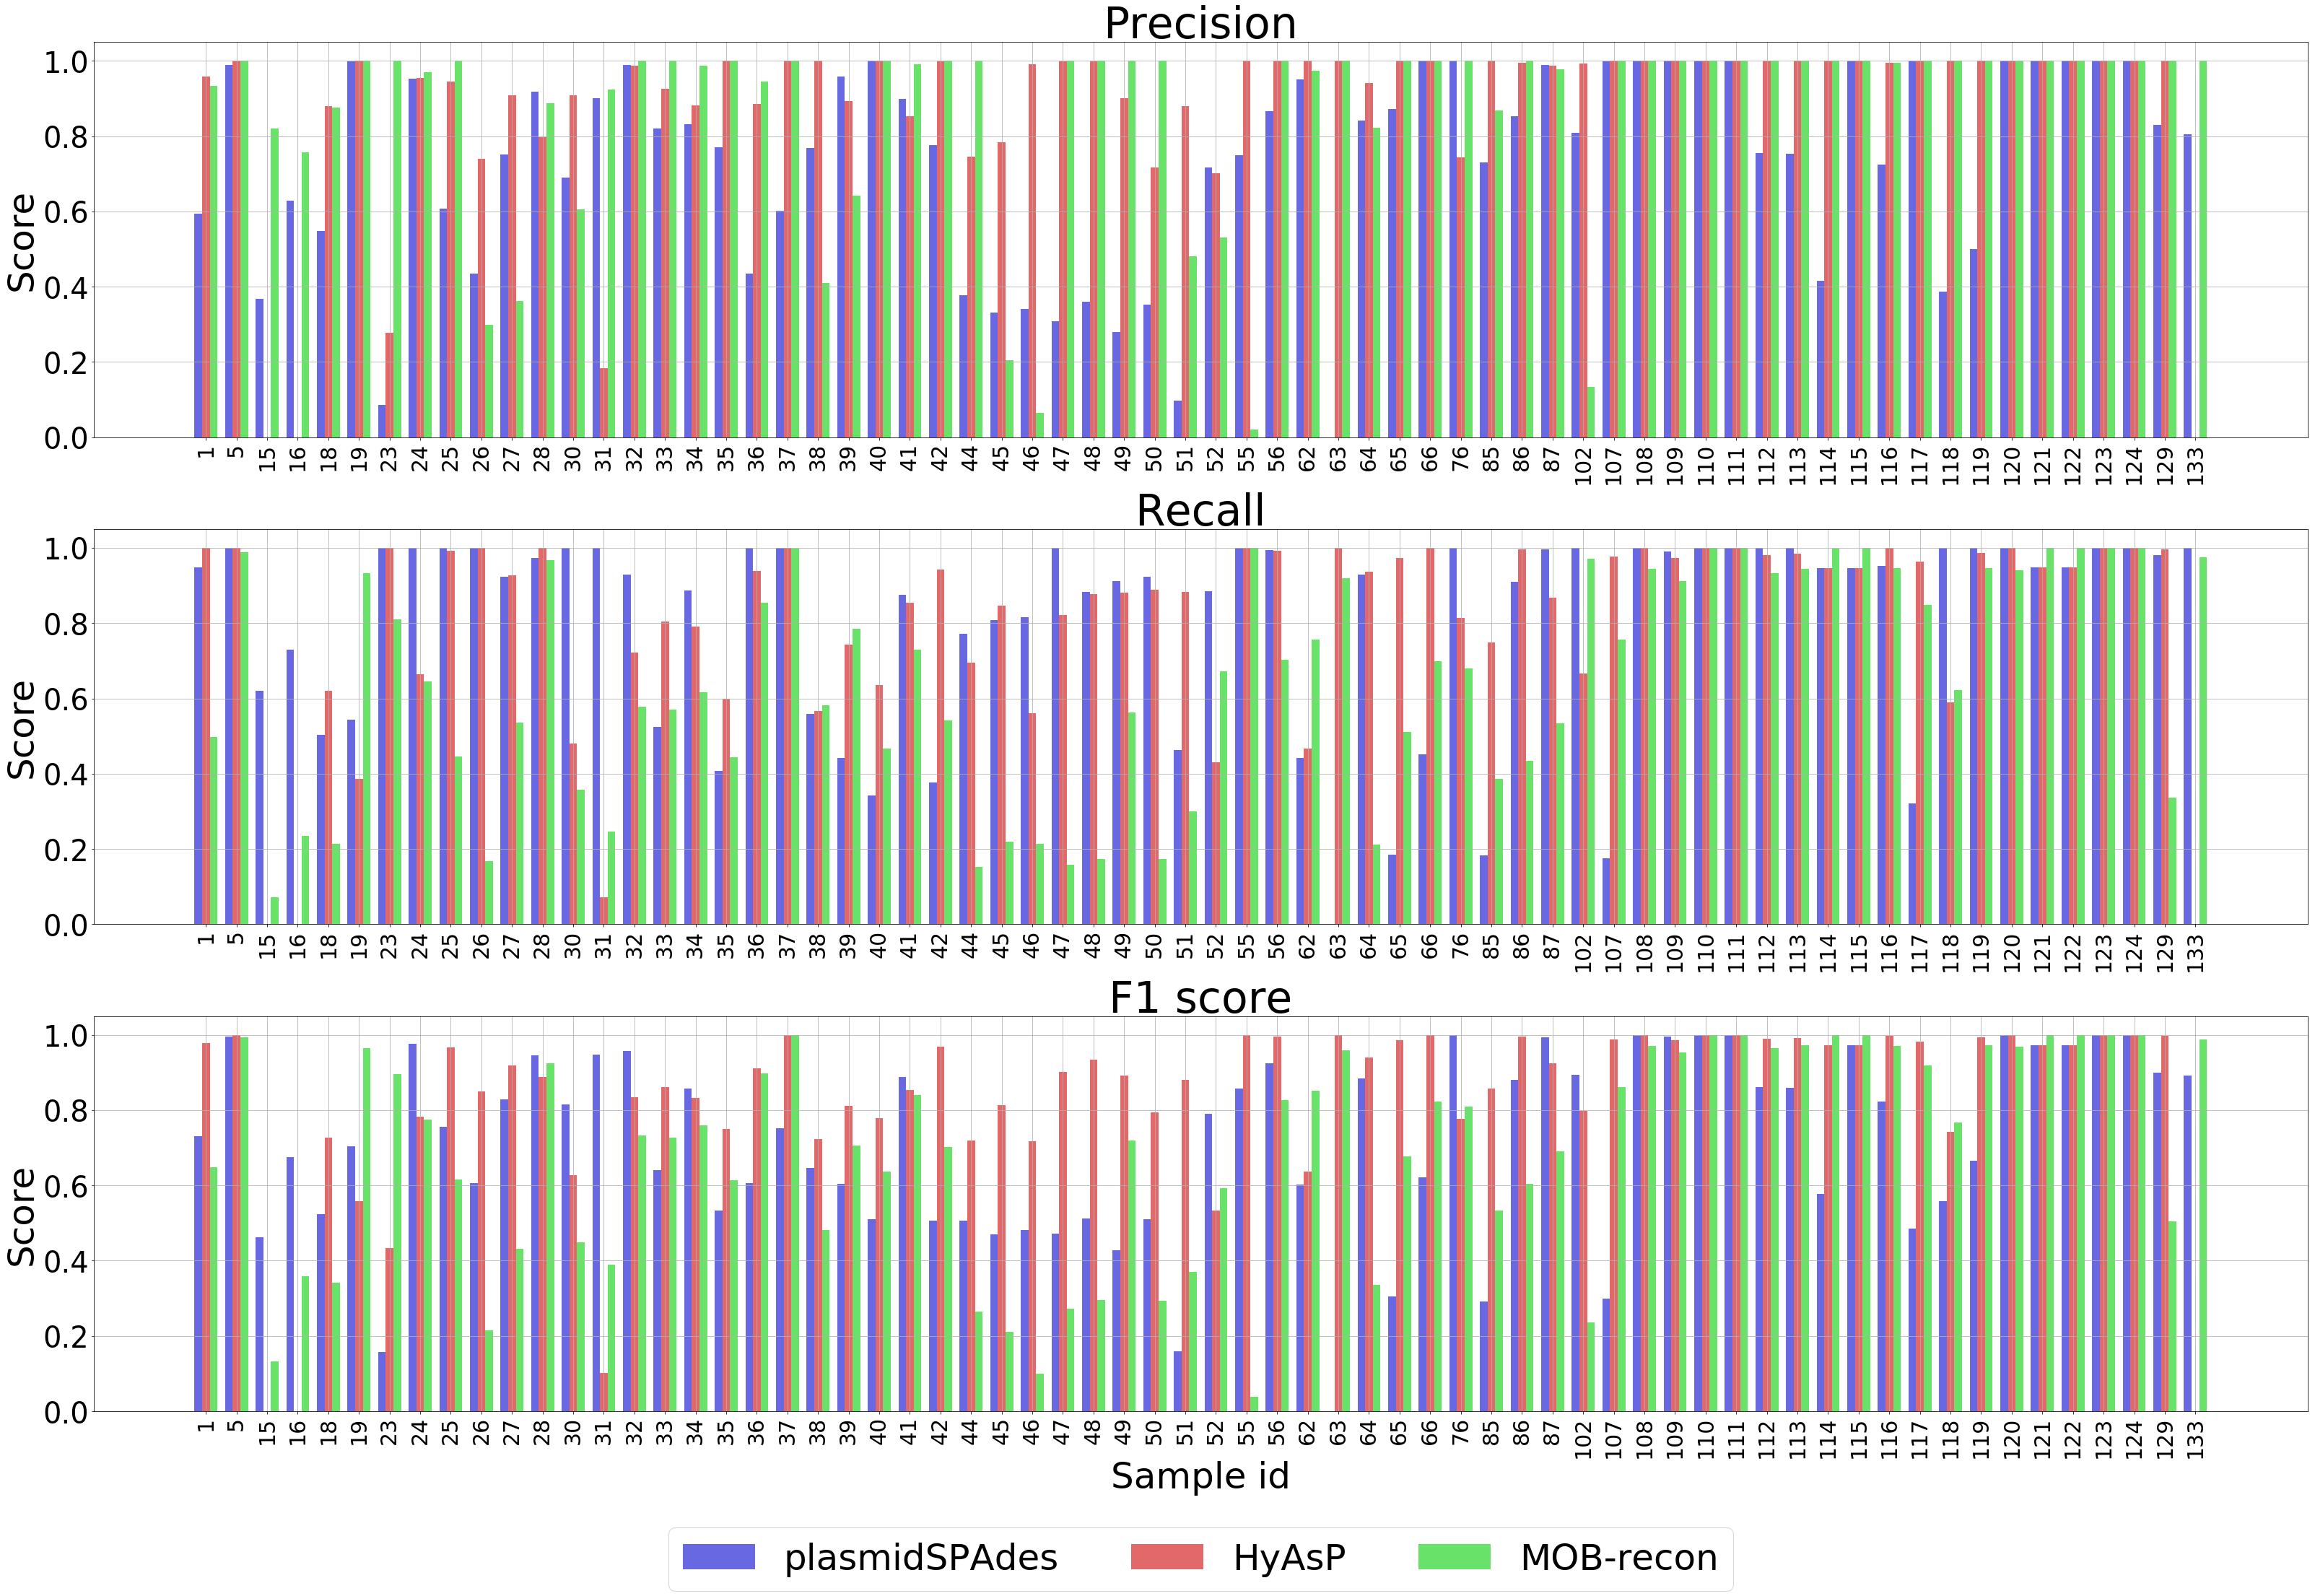

In [11]:
def plot_scores_per_sample(df, score_labels, nr = 3, fs = (45, 30)):
    fig, axes = plt.subplots(nrows = nr, figsize = fs)
    # with transparency (alpha = 0.7)
    #alpha = 0.7
    #colours = ['#2728d6', '#d62728', '#27d628']
    # without transparency
    alpha = 1.0
    colours = ['#6869e2', '#e26869', '#68e269']
    num_samples = len(df['sample'].unique())
    pos = list(range(num_samples))
    
    i = 0
    for lab in score_labels:
        width = 1 / (len(df['tool'].unique()) + 1)
        offset = -len(df['tool'].unique()) / 2
        j = 0
        for tool in ['plasmidSPAdes', 'HyAsP', 'MOB-recon']:
            axes[i].bar([p + offset * width for p in pos], df[lab][df.tool == tool], width = width, 
                        color = colours[j], alpha = alpha, label = tool)
            j += 1
            offset += 1
        i += 1
    
    plot_labels = ['Precision', 'Recall', 'F1 score']
    for i in range(0, len(score_labels)):
        axes[i].axis('on')
        axes[i].grid()
        axes[i].set_ylabel('Score', fontsize = 50)
        axes[i].set_xticks([p - 0.5 * width for p in pos])
        axes[i].set_xticklabels(df['sample'].unique(), rotation = 90)
        axes[i].xaxis.set_tick_params(labelsize = 30)
        axes[i].yaxis.set_tick_params(labelsize = 40)
        axes[i].set_title(plot_labels[i], fontsize = 60)        
        i += 1

    axes[2].set_xlabel('Sample id', fontsize = 50)
    plt.legend(fontsize = 50, markerscale = 3, ncol = 3, loc = 'lower center', bbox_to_anchor = (0.5, -0.5))
    
    plt.subplots_adjust(hspace = 0.4)
    plt.tight_layout()
    
    plt.savefig('per_sample_mob_filtered.eps', format = 'eps', dpi = 1200, bbox_inches = 'tight')
    plt.savefig('per_sample_mob_filtered.pdf', format = 'pdf', dpi = 1200, bbox_inches = 'tight')
    #plt.savefig('per_sample_mob_filtered.png', format = 'png', dpi = 1200, bbox_inches = 'tight')
    
plot_scores_per_sample(scores_per_sample, ['Precision', 'Recall', 'F1 score'])

### Differences in precision, recall and F1 score per sample

*Compute differences*

In [12]:
scores_diffs = []
sample_groups = scores.groupby('sample_id')
for sample_id, group in sample_groups:
    greedy_precision = group['Precision'][group['tool'] == 'HyAsP'].item()
    greedy_recall = group['Recall'][group['tool'] == 'HyAsP'].item()
    greedy_f1 = group['F1 score'][group['tool'] == 'HyAsP'].item()
    for other in ['plasmidSPAdes', 'MOB-recon']:
        scores_diffs.append([other, sample_id, 
                            group['Recall'][group['tool'] == other].item() - greedy_recall, 
                            group['Precision'][group['tool'] == other].item() - greedy_precision,
                            group['F1 score'][group['tool'] == other].item() - greedy_f1])

scores_diffs = pd.DataFrame(scores_diffs)
scores_diffs.rename(columns = {0: 'tool', 1: 'sample_id', 2: 'Recall', 3: 'Precision', 4: 'F1 score'}, inplace = True)

**Difference in precision, recall and F1 score between HyAsP and plasmidSPAdes and MOB-recon**

The zero line represents the respective score of HyAsP. 
Positive (negative) values indicate that the other tool performed better (worse) than HyAsP.

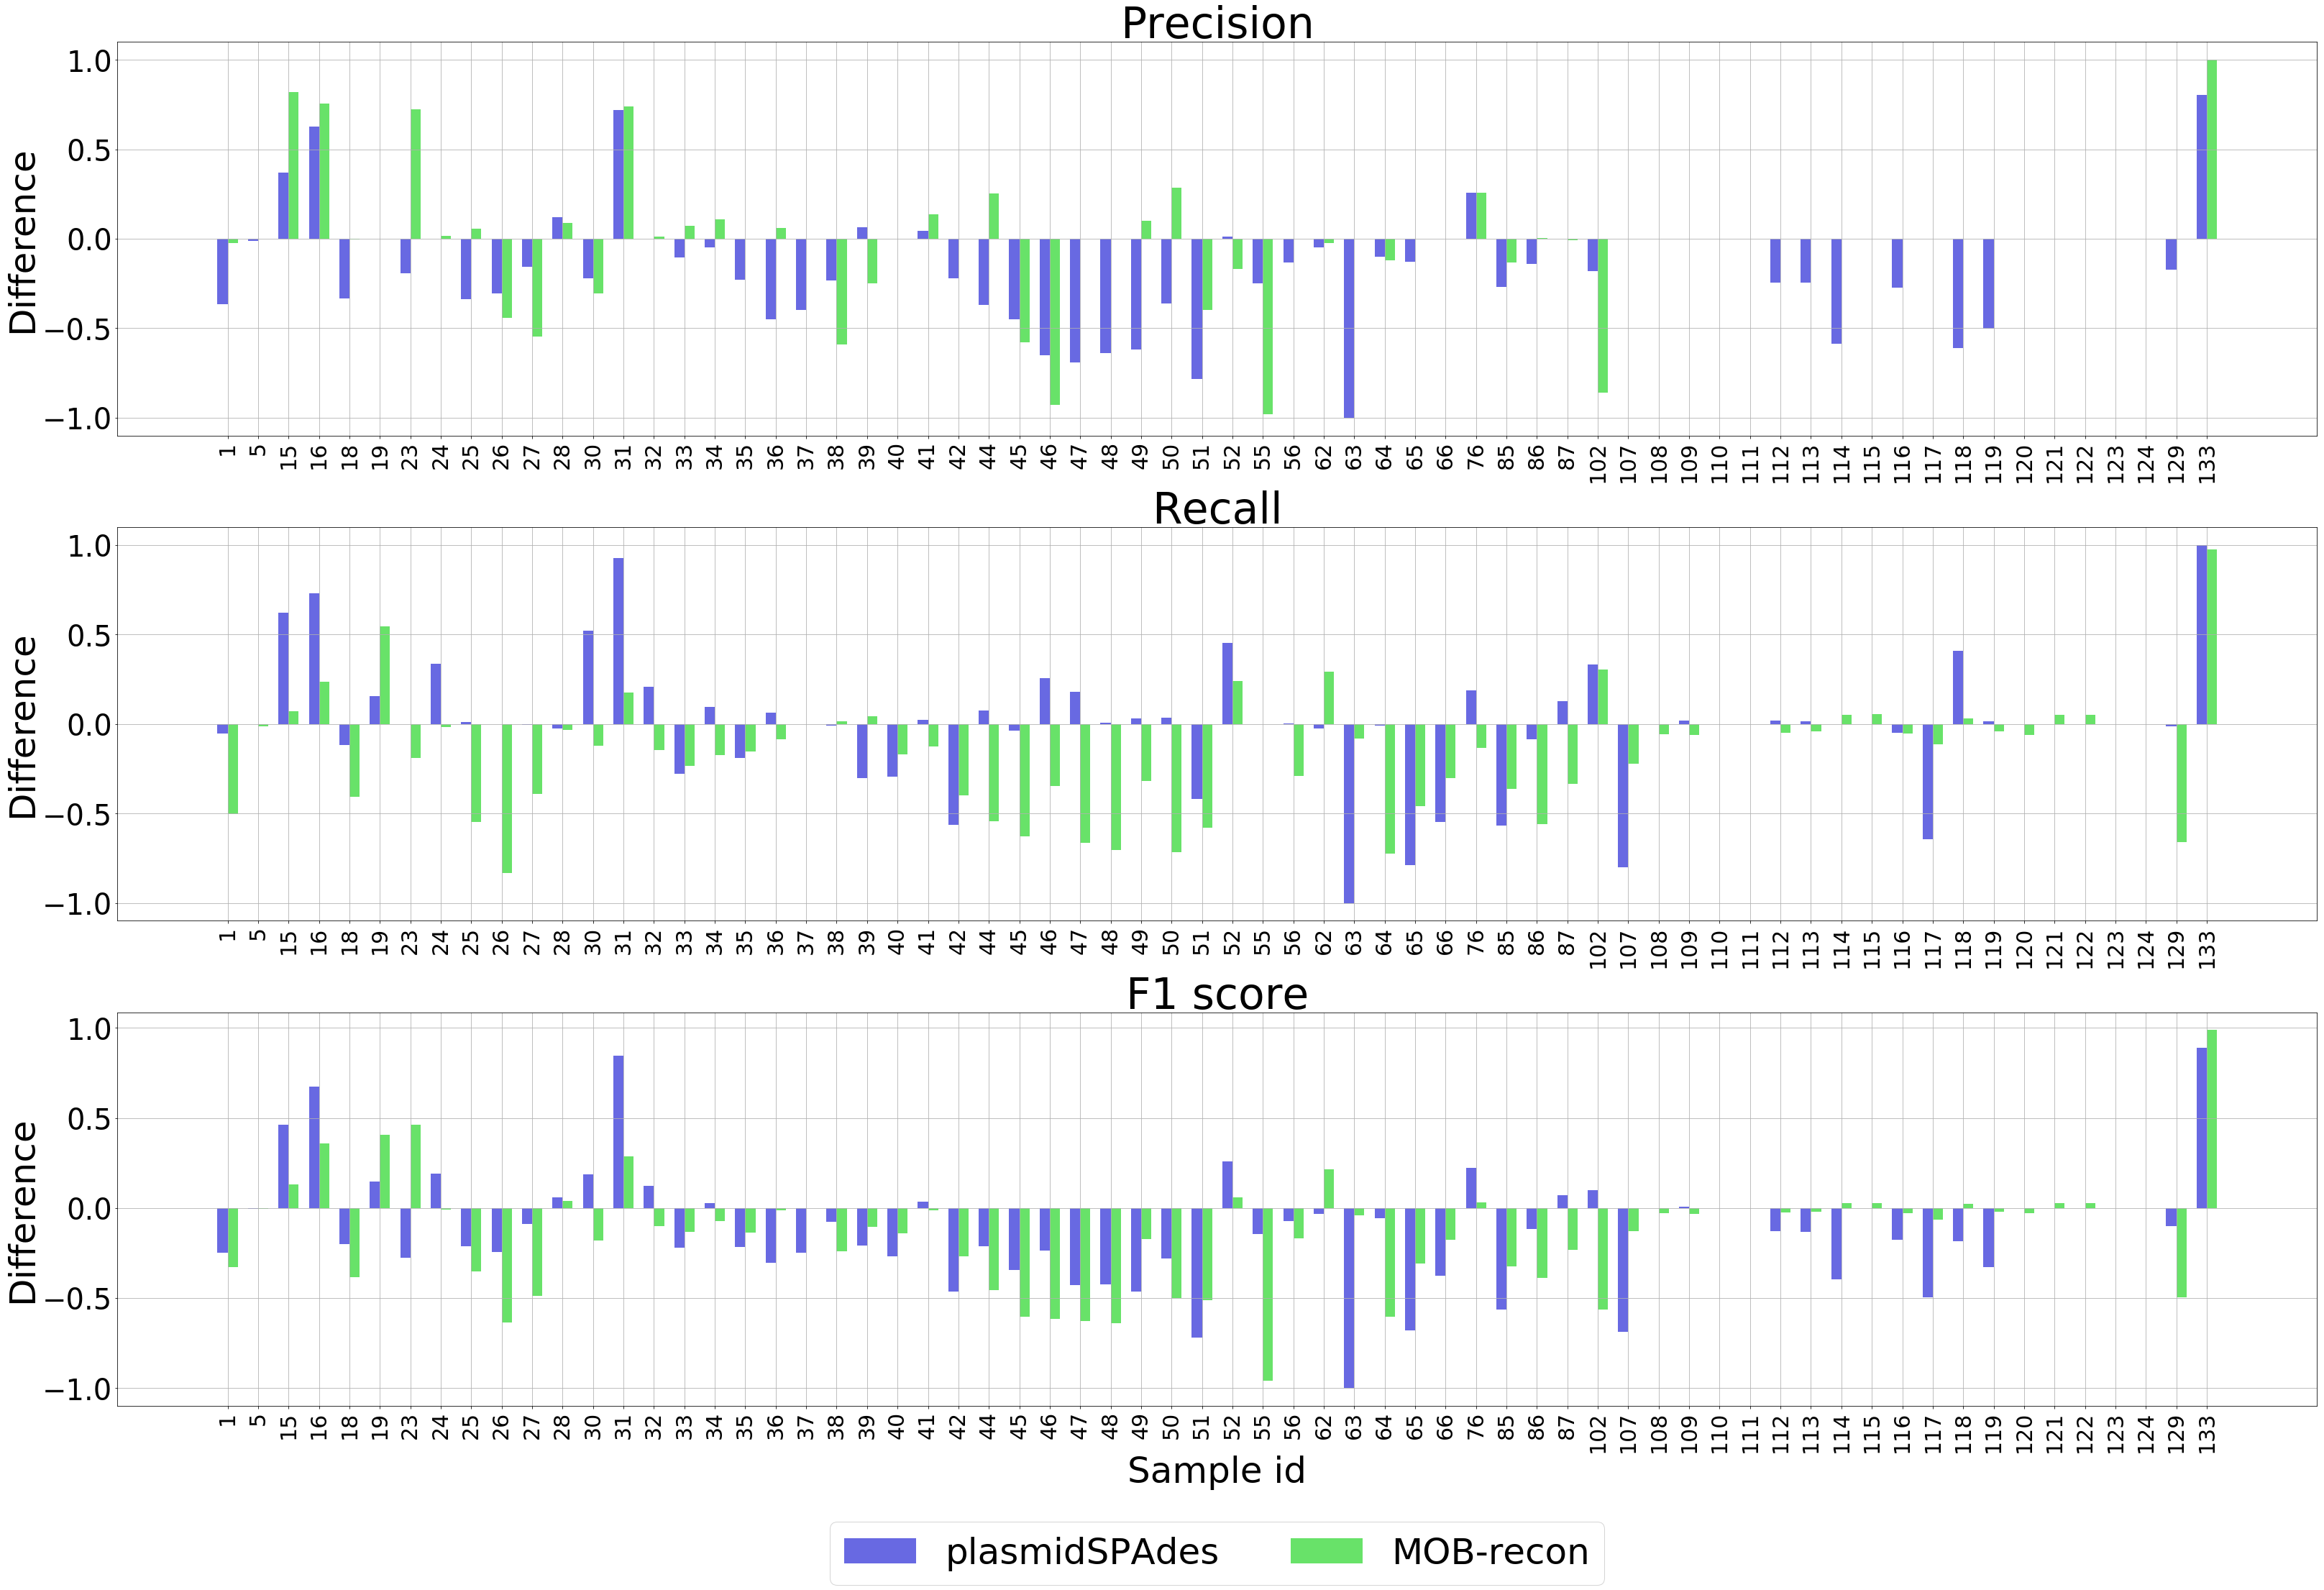

In [13]:
def plot_score_differences_per_sample(df, score_labels, nr = 3, fs = (45, 30)):
    fig, axes = plt.subplots(nrows = nr, figsize = fs)
    # with transparency (alpha = 0.7)
    #alpha = 0.7
    #colours = ['#2728d6', '#27d628']
    # without transparency
    alpha = 1.0
    colours = ['#6869e2', '#68e269']
    num_samples = len(df['sample_id'].unique())
    pos = list(range(num_samples))
    
    i = 0
    for lab in score_labels:
        width = 1 / (len(df['tool'].unique()) + 1)
        offset = -len(df['tool'].unique()) / 2
        j = 0
        for tool in df['tool'].unique():
            axes[i].bar([p + offset * width for p in pos], df[lab][df['tool'] == tool], width = width, 
                        color = colours[j], alpha = alpha, label = tool)
            j += 1
            offset += 1
        i += 1
    
    for i in range(0, len(score_labels)):
        axes[i].axis('on')
        axes[i].grid()
        axes[i].set_ylabel('Difference', fontsize = 50)
        axes[i].set_xticks([p - 0.5 * width for p in pos])
        axes[i].set_xticklabels(df['sample_id'].unique(), rotation = 90)
        axes[i].xaxis.set_tick_params(labelsize = 30)
        axes[i].yaxis.set_tick_params(labelsize = 40)
        axes[i].set_title(score_labels[i], fontsize = 60)        
        i += 1

    axes[2].set_xlabel('Sample id', fontsize = 50)
    plt.legend(fontsize = 50, markerscale = 3, ncol = 2, loc = 'lower center', bbox_to_anchor = (0.5, -0.5))
    
    plt.subplots_adjust(hspace = 0.4)
    plt.tight_layout()
    
    plt.savefig('differences_mob_filtered.eps', format = 'eps', dpi = 1200, bbox_inches = 'tight')
    plt.savefig('differences_mob_filtered.pdf', format = 'pdf', dpi = 1200, bbox_inches = 'tight')
    #plt.savefig('differences_mob_filtered.png', format = 'png', dpi = 1200, bbox_inches = 'tight')
    
plot_score_differences_per_sample(scores_diffs, ['Precision', 'Recall', 'F1 score'])

### Distributions of precision, recall and F1 score

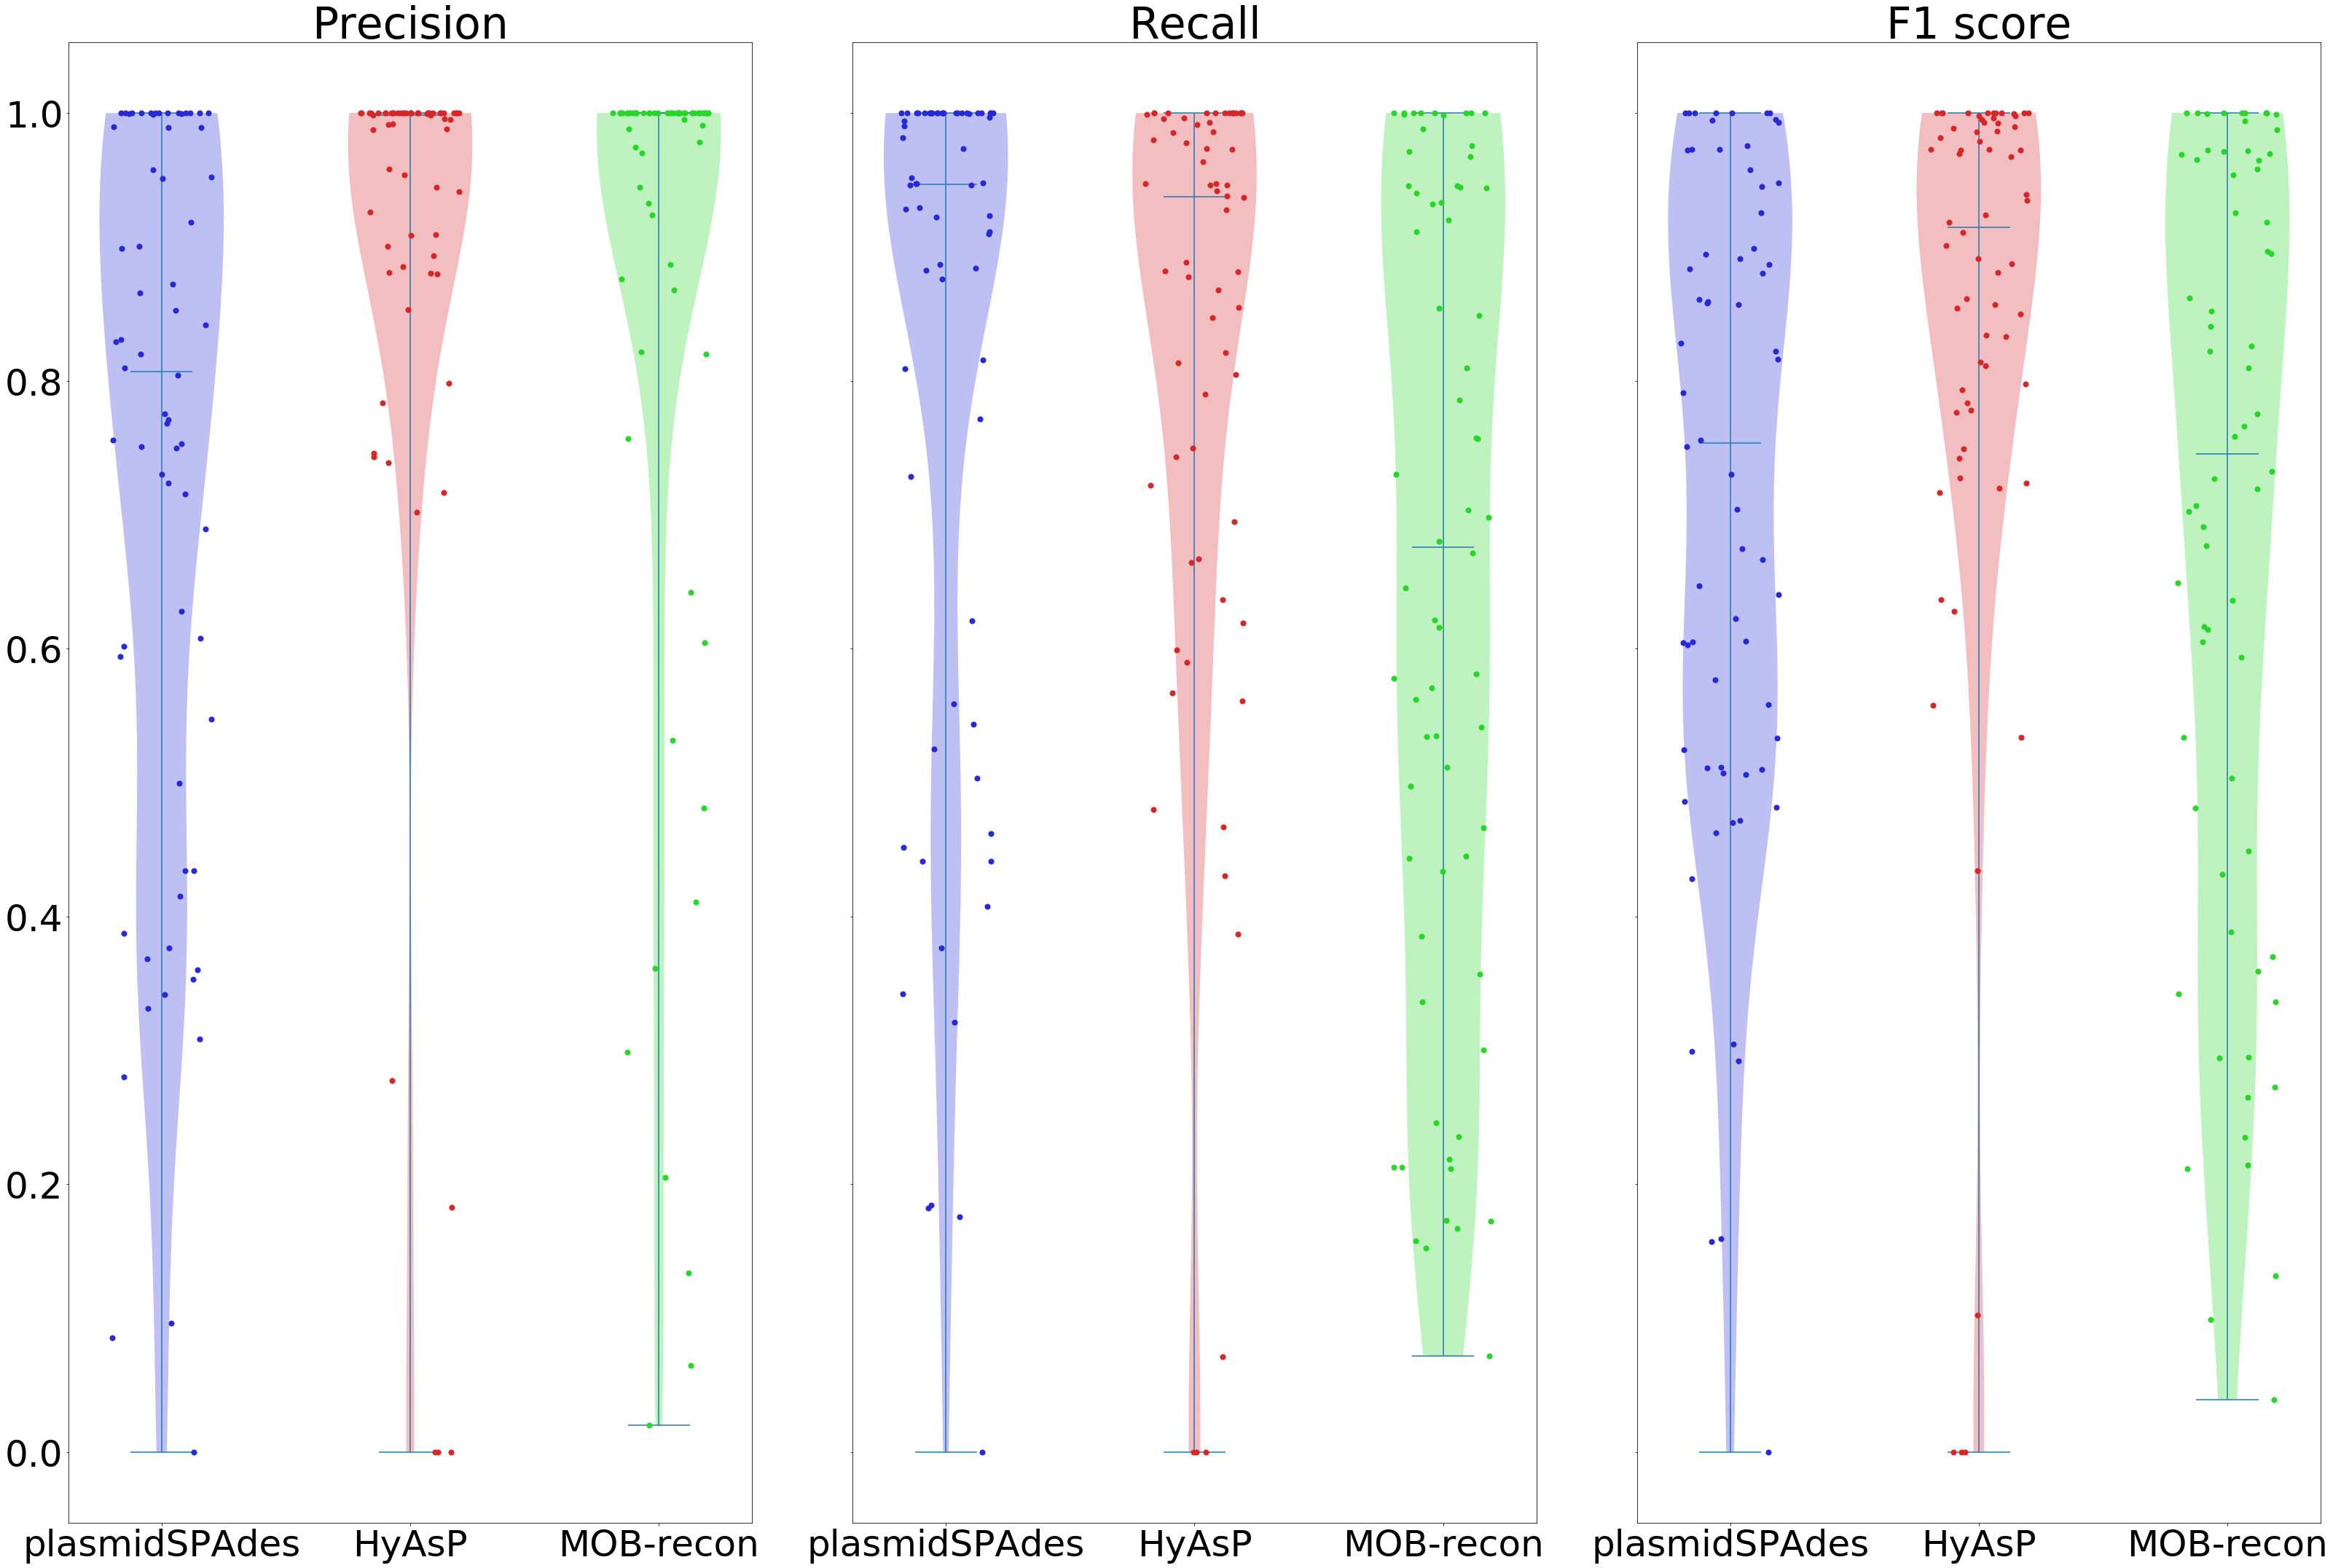

In [14]:
greedy_putative_rows = scores['tool'] == 'HyAsP'
plasmidspades_rows = scores['tool'] == 'plasmidSPAdes'
mob_recon_rows = scores['tool'] == 'MOB-recon'

precision_values = [scores['Precision'][plasmidspades_rows], scores['Precision'][greedy_putative_rows], scores['Precision'][mob_recon_rows]]
recall_values = [scores['Recall'][plasmidspades_rows], scores['Recall'][greedy_putative_rows], scores['Recall'][mob_recon_rows]]
f1_score_values = [scores['F1 score'][plasmidspades_rows], scores['F1 score'][greedy_putative_rows], scores['F1 score'][mob_recon_rows]]

tool_labels = ['plasmidSPAdes', 'HyAsP', 'MOB-recon']

# with transparency
#def create_subplot(fig, axes, c, title, data, labels, scatter_colours = ['#2728d6', '#d62728', '#27d628'], 
#                   colours = ['#2728d6', '#d62728', '#27d628'], alpha = 0.3):
# without transparency
def create_subplot(fig, axes, c, title, data, labels, scatter_colours = ['#2728d6', '#d62728', '#27d628'], 
                   colours = ['#bebff3', '#f3bebf', '#bef3bf'], alpha = 1.0):
    parts = axes[c].violinplot(data, showextrema = True, showmedians = True)
    axes[c].set_title(title, fontsize = 60)
    for i in range(0, len(data)):
        inds = [i + 1 + random.uniform(-0.2, 0.2) for d in data[i]]
        axes[c].scatter(inds, data[i], color = scatter_colours[i], alpha = 1, s = 50, zorder = 3, label = labels[i])
        parts['bodies'][i].set_facecolor(colours[i])
        parts['bodies'][i].set_alpha(alpha)

fig, axes = plt.subplots(ncols = 3, figsize = (45, 30), sharey = 'row')

create_subplot(fig, axes, 0, 'Precision', precision_values, tool_labels)
create_subplot(fig, axes, 1, 'Recall', recall_values, tool_labels)
create_subplot(fig, axes, 2, 'F1 score', f1_score_values, tool_labels)

for ax in axes.flatten():
    ax.yaxis.set_tick_params(labelsize = 50)
    ax.xaxis.set_tick_params(labelsize = 50)
    labels = tool_labels
    ax.set_xticks([1, 2, 3])
    ax.set_xticklabels(labels)
plt.tight_layout()

plt.savefig('distributions_mob_filtered.eps', format = 'eps', dpi = 1200)
plt.savefig('distributions_mob_filtered.pdf', format = 'pdf', dpi = 1200)
#plt.savefig('distributions_mob.png', format = 'png', dpi = 1200)

### Statistics for precision, recall and F1 score

In [15]:
precision_stats = []
recall_stats = []
f1_stats = []
tool_groups = scores.groupby('tool')
for tool, group in tool_groups:
    col = group['Precision']
    precision_stats.append([tool, col.min(), col.mean(), col.std(), col.quantile(0.25), 
                            col.quantile(0.5), col.quantile(0.75), col.max()])
    col = group['Recall']
    recall_stats.append([tool, col.min(), col.mean(), col.std(), col.quantile(0.25), 
                         col.quantile(0.5), col.quantile(0.75), col.max()])
    col = group['F1 score']
    f1_stats.append([tool, col.min(), col.mean(), col.std(), col.quantile(0.25), 
                     col.quantile(0.5), col.quantile(0.75), col.max()])

precision_stats = pd.DataFrame(precision_stats)
recall_stats = pd.DataFrame(recall_stats)
f1_stats = pd.DataFrame(f1_stats)
precision_stats.rename(columns = {0: 'tool', 1: 'min', 2: 'mean', 3: 'sd', 4: 'q25', 5: 'median', 6: 'q75', 7: 'max'}, inplace = True)
recall_stats.rename(columns = {0: 'tool', 1: 'min', 2: 'mean', 3: 'sd', 4: 'q25', 5: 'median', 6: 'q75', 7: 'max'}, inplace = True)
f1_stats.rename(columns = {0: 'tool', 1: 'min', 2: 'mean', 3: 'sd', 4: 'q25', 5: 'median', 6: 'q75', 7: 'max'}, inplace = True)

**Statistics of precision values across test samples**

In [16]:
precision_stats

,tool,min,mean,sd,q25,median,q75,max
0,HyAsP,0.0000,0.884099,0.244637,0.887507,0.998471,1.000000,1.0
1,MOB-recon,0.0201,0.870913,0.257858,0.896047,1.000000,1.000000,1.0
2,plasmidSPAdes,0.0000,0.731891,0.272826,0.559195,0.806760,0.989693,1.0


**Statistics of recall values across test samples**

In [17]:
recall_stats

,tool,min,mean,sd,q25,median,q75,max
0,HyAsP,0.000000,0.807942,0.262813,0.701714,0.937535,0.996157,1.0
1,MOB-recon,0.071675,0.648591,0.298650,0.436172,0.675785,0.944612,1.0
2,plasmidSPAdes,0.000000,0.808190,0.270534,0.647659,0.946650,1.000000,1.0


**Statistics of F1 scores across test samples**

In [18]:
f1_stats

,tool,min,mean,sd,q25,median,q75,max
0,HyAsP,0.000000,0.830526,0.244144,0.779238,0.914635,0.991880,1.0
1,MOB-recon,0.039408,0.690134,0.285472,0.457057,0.745663,0.965336,1.0
2,plasmidSPAdes,0.000000,0.712765,0.248320,0.514948,0.753543,0.940200,1.0


## Total scores per species

*Aggregate total scores per species*

In [19]:
aggregated_scores_per_org = []
org_groups = test_samples.groupby('Organism')
for org, group in org_groups:
    org_scores = scores_per_sample[scores_per_sample['sample'].isin(list(group['SampleId']))]
    tool_groups = org_scores.groupby('tool')
    for tool in ['plasmidSPAdes', 'HyAsP', 'MOB-recon']:
        grp = tool_groups.get_group(tool)
        total_precision = grp['precise_nt'].sum() / grp['total_length_preds'].sum() if grp['total_length_preds'].sum() > 0 else 0
        total_recall = grp['recalled_nt'].sum() / grp['total_length_refs'].sum() if grp['total_length_refs'].sum() > 0 else 0
        total_f1_score = 2 * (total_recall * total_precision) / (total_recall + total_precision) if total_recall + total_precision > 0 else 0
        aggregated_scores_per_org.append([org, tool, total_precision, total_recall, total_f1_score])
aggregated_scores_per_org = pd.DataFrame(aggregated_scores_per_org)
aggregated_scores_per_org.rename(columns = {0: 'Organism', 1: 'Tool', 2: 'Precision', 3: 'Recall', 4: 'F1 score'}, inplace = True)

**Total precision, recall and F1 score per species**

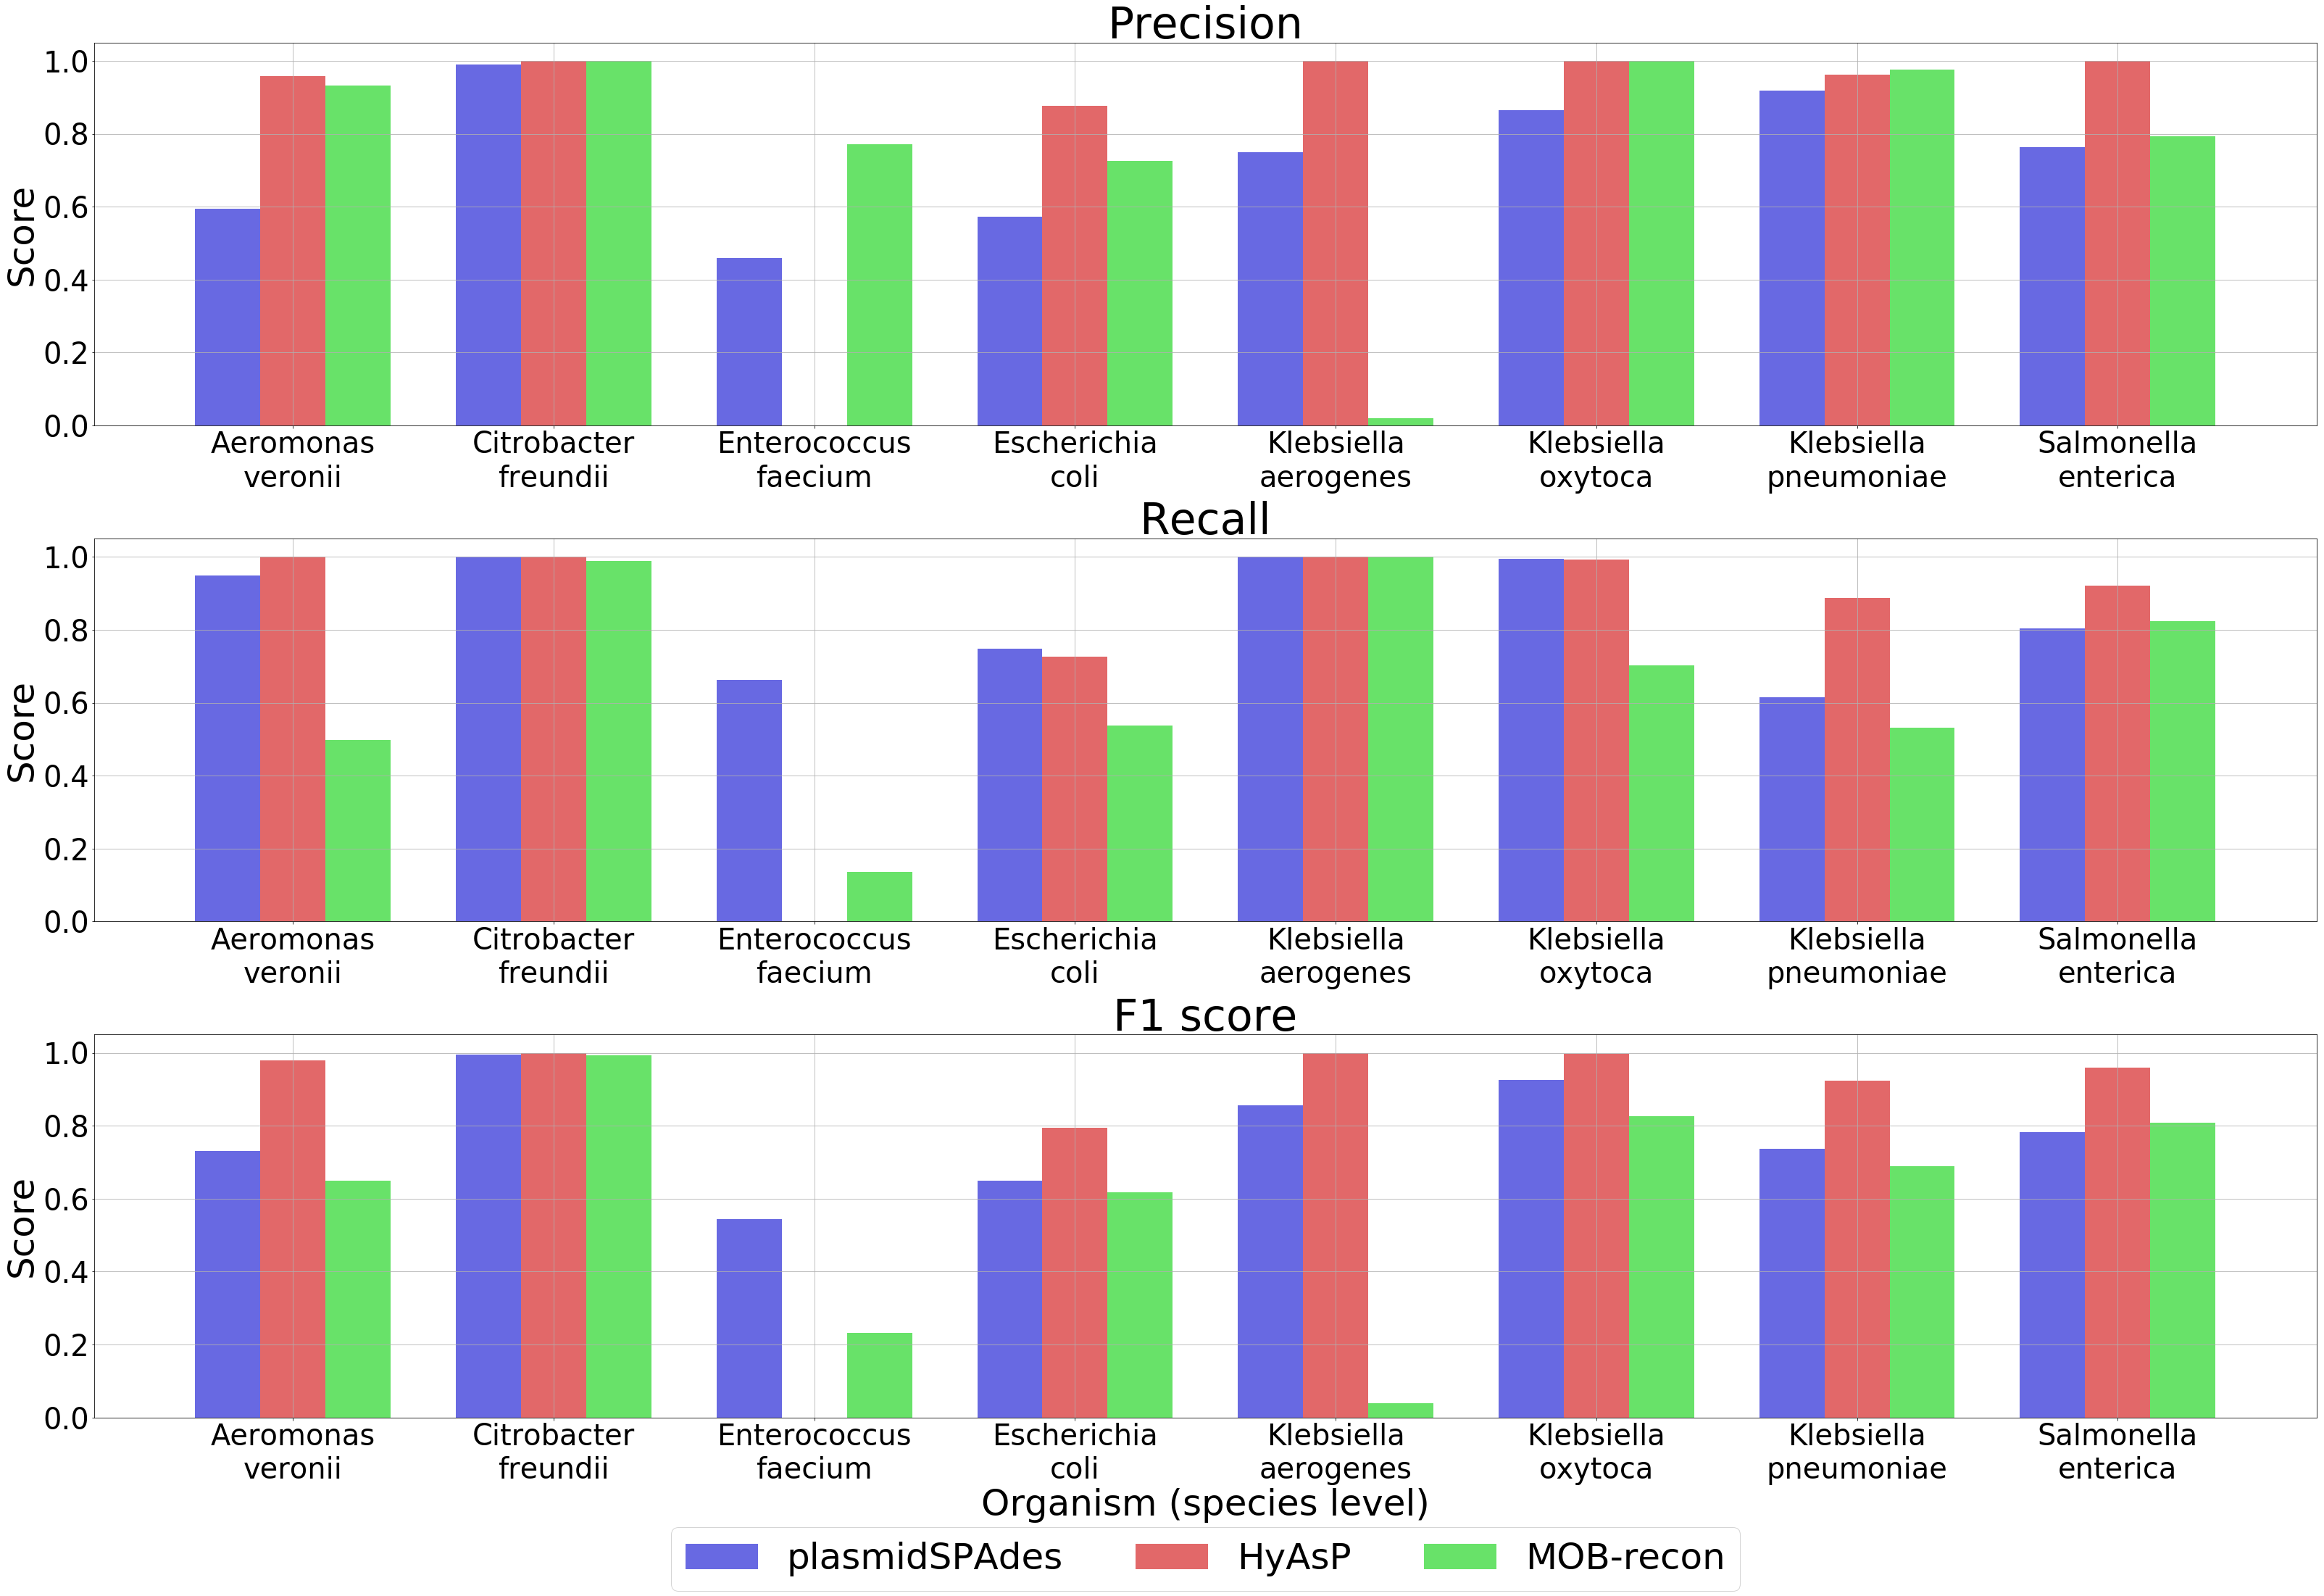

In [20]:
def plot_scores_per_org(df, score_labels, nr = 3, fs = (45, 30)):
    fig, axes = plt.subplots(nrows = nr, figsize = fs)
    # with transparency (alpha = 0.7)
    #alpha = 0.7
    #colours = ['#2728d6', '#d62728', '#27d628']
    # without transparency
    alpha = 1.0
    colours = ['#6869e2', '#e26869', '#68e269']
    num_orgs = len(df['Organism'].unique())
    pos = list(range(num_orgs))
    
    i = 0
    for lab in score_labels:
        width = 1 / (len(df['Tool'].unique()) + 1)
        offset = -len(df['Tool'].unique()) / 2
        j = 0
        for tool in df['Tool'].unique():
            axes[i].bar([p + offset * width for p in pos], df[lab][df['Tool'] == tool], width = width, 
                        color = colours[j], alpha = alpha, label = tool)
            j += 1
            offset += 1
        i += 1
    
    plot_labels = ['Precision', 'Recall', 'F1 score']
    for i in range(0, len(score_labels)):
        axes[i].axis('on')
        axes[i].grid()
        axes[i].set_ylabel('Score', fontsize = 50)
        axes[i].set_xticks([p - 0.5 * width for p in pos])
        axes[i].set_xticklabels([s.replace(' ', '\n') for s in df['Organism'].unique()])
        axes[i].xaxis.set_tick_params(labelsize = 40)
        axes[i].yaxis.set_tick_params(labelsize = 40)
        axes[i].set_title(plot_labels[i], fontsize = 60)        
        i += 1

    axes[2].set_xlabel('Organism (species level)', fontsize = 50)
    plt.legend(fontsize = 50, markerscale = 3, ncol = 3, loc = 'lower center', bbox_to_anchor = (0.5, -0.5))
    
    plt.subplots_adjust(hspace = 0.4)
    plt.tight_layout()
    
    plt.savefig('per_species_mob_filtered.eps', format = 'eps', dpi = 1200, bbox_inches = 'tight')
    plt.savefig('per_species_mob_filtered.pdf', format = 'pdf', dpi = 1200, bbox_inches = 'tight')
    #plt.savefig('per_sample_mob_filtered.png', format = 'png', dpi = 1200, bbox_inches = 'tight')
    
plot_scores_per_org(aggregated_scores_per_org, ['Precision', 'Recall', 'F1 score'])